In [36]:
# Importing Libraries


import pandas as pd 
import plotly.graph_objects as go 
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import plotly.express as px 
import plotly.io as pio 
pio.templates.default = 'plotly_white'


In [38]:
# Importing Data 


df = pd.read_csv('chatgpt_reviews.csv')


In [40]:
df.head()

,Review Id,Review,Ratings,Review Date
0,6fb93778-651a-4ad1-b5ed-67dd0bd35aac,good,5,2024-08-23 19:30:05
1,81caeefd-3a28-4601-a898-72897ac906f5,good,5,2024-08-23 19:28:18
2,452af49e-1d8b-4b68-b1ac-a94c64cb1dd5,nice app,5,2024-08-23 19:22:59
3,372a4096-ee6a-4b94-b046-cef0b646c965,"nice, ig",5,2024-08-23 19:20:50
4,b0d66a4b-9bde-4b7c-8b11-66ed6ccdd7da,"this is a great app, the bot is so accurate to...",5,2024-08-23 19:20:39


In [42]:
# Checking Null Values 

df.isnull().sum()

Review Id      0
Review         6
Ratings        0
Review Date    0
dtype: int64

In [44]:
# Replacing NaN vals in Review with ''

df['Review']=df['Review'].astype(str).fillna('')

In [46]:
# Sentiment Ananlysis

!pip install textblob

from textblob import TextBlob

In [47]:
# determining Sentiment Polarity 

def get_sentiment(review):
    sentiment = TextBlob(review).sentiment.polarity
    if sentiment>0:
        return 'Positive'
    elif sentiment<0:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment'] = df['Review'].apply(get_sentiment)
sentiment_distribution = df['Sentiment'].value_counts()
df['Sentiment'] = df['Sentiment'].astype(str)


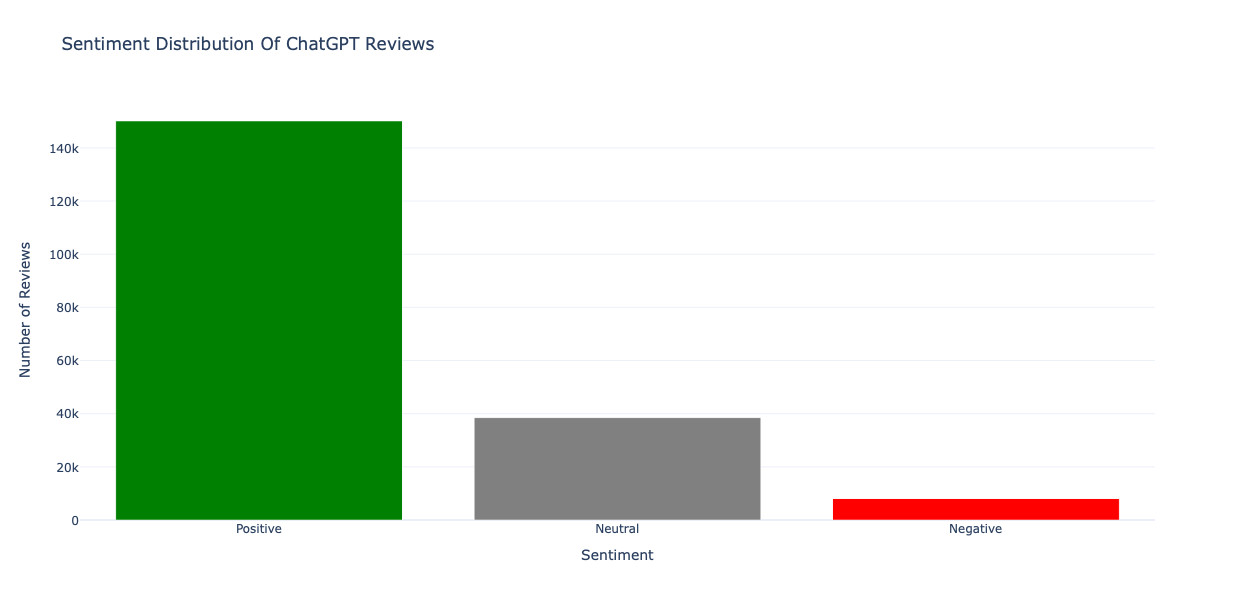

In [50]:
# Distribution of Positive, Negative and Neutral Reviews 

fig = go.Figure(data = [go.Bar(x = sentiment_distribution.index ,
                               y = sentiment_distribution.values,
                               marker_color = ['green','grey','red'])])

fig.update_layout(title = 'Sentiment Distribution Of ChatGPT Reviews',
                  xaxis_title = 'Sentiment',
                  yaxis_title = 'Number of Reviews', 
                  width = 800, height=600)
fig.show()

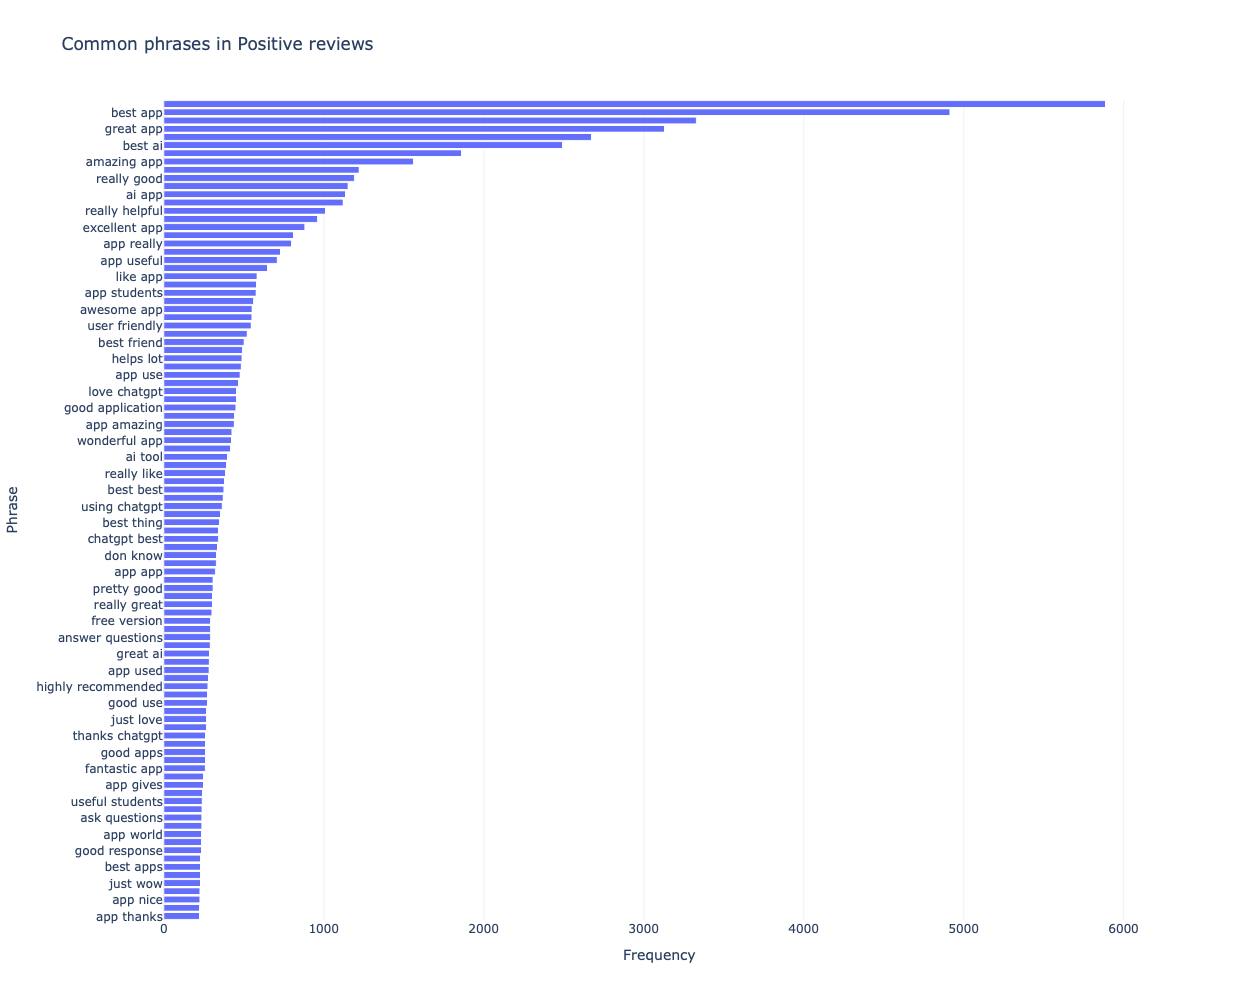

In [18]:
# Analyzing What Users Like About ChatGPT

# Filtering reviews with positive sentiment 
positive_reviews = df[df['Sentiment'] == 'Positive']['Review']

# Using CountVectorizer to extract common phrases 
vectorizer = CountVectorizer(ngram_range=(2,3),stop_words='english',max_features=100)
X = vectorizer.fit_transform(positive_reviews)

#Sum the count of each phrase 
phrase_counts = X.sum(axis = 0)
phrases = vectorizer.get_feature_names_out()
phrase_freq = [(phrases[i], phrase_counts[0, i]) for i in range(len(phrases))]   

# Sort phrases by frequency 
phrase_freq = sorted(phrase_freq, key =lambda x: x[1], reverse = True)
phrase_df = pd.DataFrame(phrase_freq,columns = ['Phrase','Frequency'])

fig = px.bar(phrase_df,
             x='Frequency',
             y='Phrase',
             orientation='h',
             title = 'Common phrases in Positive reviews',
             labels={'Phrase':'Phrase','Frequency':'Frequency'},
             width = 1200,
             height=1000)
fig.update_layout(
    xaxis_title = 'Frequency',
    yaxis_title = 'Phrase',
    yaxis={'categoryorder':'total ascending'})
fig.show()

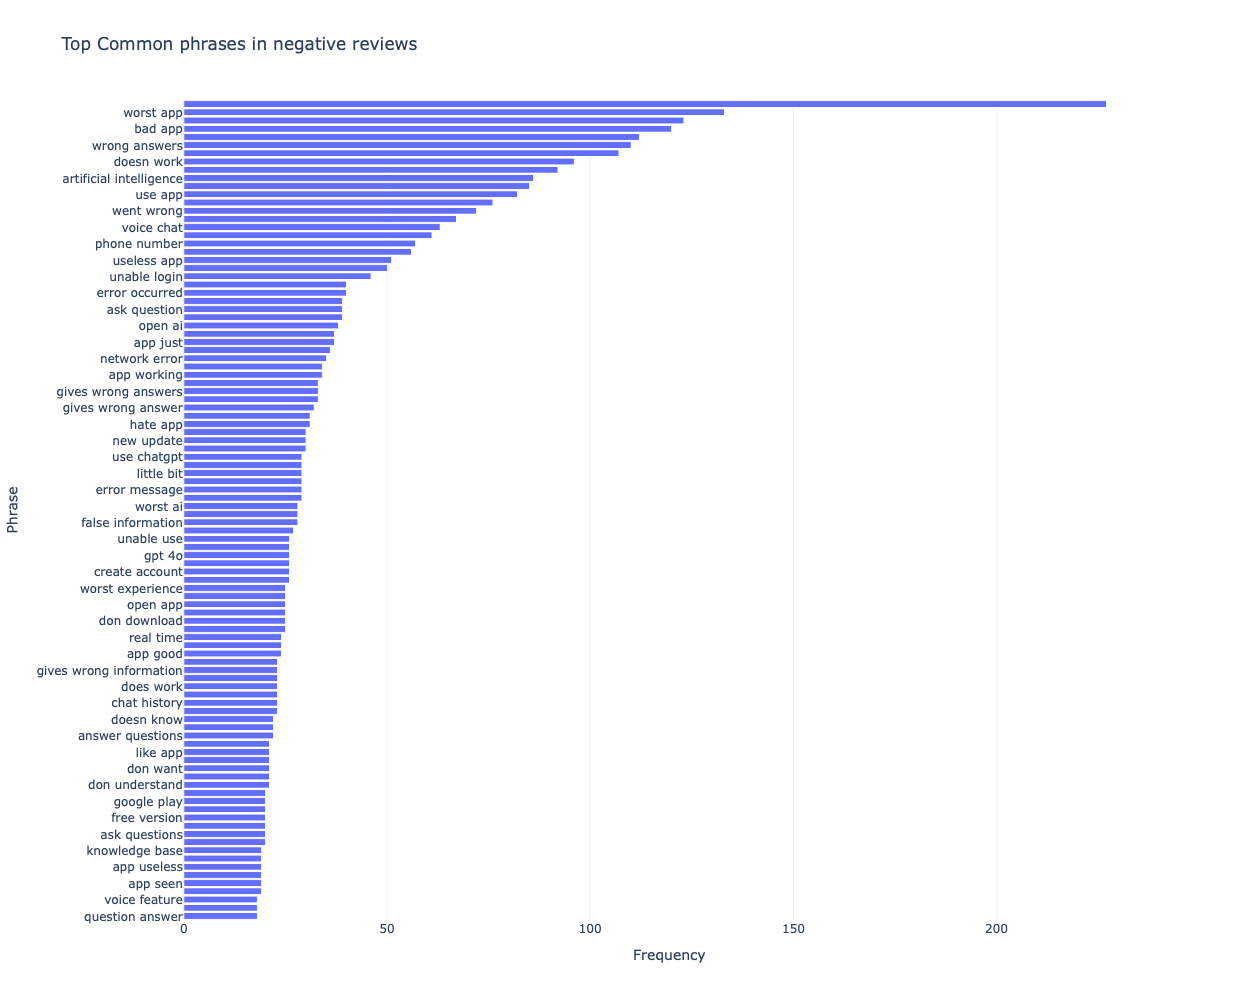

In [80]:
# Analyzing what users don't like about ChatGPT

# filter reviews with negative sentiment 
negative_reviews = df[df['Sentiment']=='Negative']['Review']

# Use Count vectorizer to extract common phrases(n-grams) for negative reviews 
X_neg = vectorizer.fit_transform(negative_reviews)

# Sum the count of each phrase in negative reviews
phrase_counts_neg = X_neg.sum(axis=0)
phrases_neg = vectorizer.get_feature_names_out()
phrase_freq_neg = [(phrases_neg[i],phrase_counts_neg[0,i]) for i in range(len(phrases_neg))]

#Sort phrases by frequency 
phrase_freq_neg = sorted(phrase_freq_neg,key = lambda x:x[1],reverse = True)

phrase_neg_df = pd.DataFrame(phrase_freq_neg,columns = ['Phrase','Frequency'])

# plotting 
fig = px.bar(phrase_neg_df,
             x='Frequency',
             y='Phrase',
             orientation ='h',
             title='Top Common phrases in negative reviews',
             labels={'Phrase':'Phrase','Frequency':'Frequency'},
             width=1200,
             height=1000)
fig.update_layout(
    xaxis_title = 'Frequency',
    yaxis_title = 'Phrase',
    yaxis={'categoryorder':'total ascending'}
)
fig.show()
             

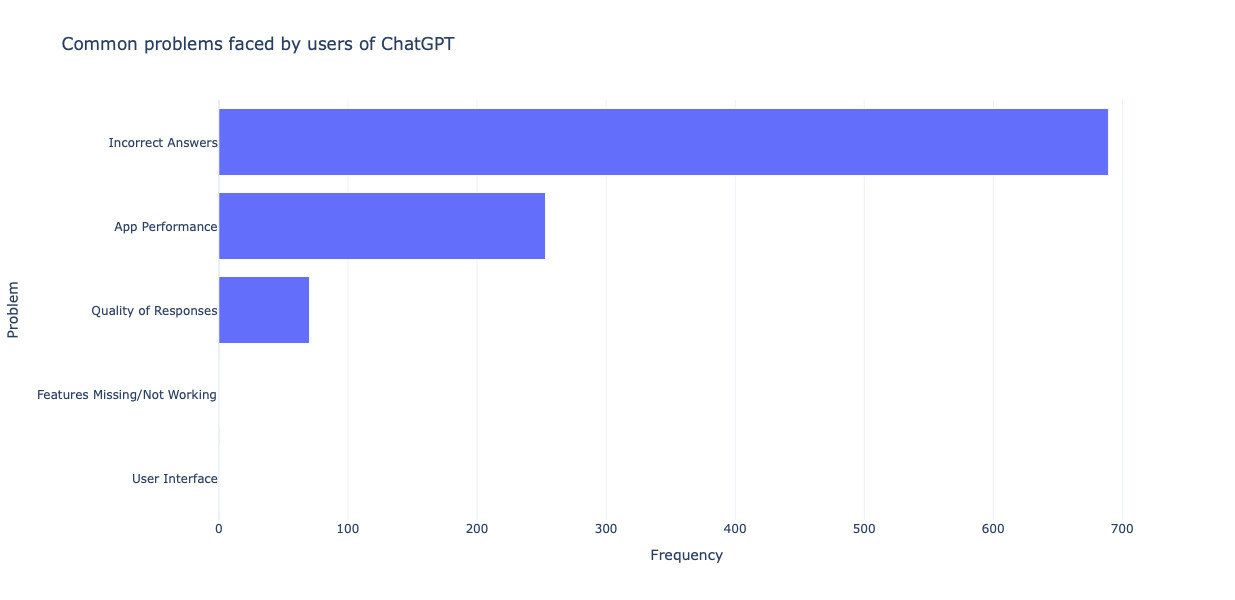

In [88]:
# Common Problems faced by users in ChatGPT

# Grouping similar problems into broader problem category 
problem_keywords = {
    'Incorrect Answers': ['wrong answer', 'gives wrong', 'incorrect', 'inaccurate', 'wrong'],
    'App Performance': ['slow', 'lag', 'crash', 'bug', 'freeze', 'loading', 'glitch', 'worst app', 'bad app', 'horrible', 'terrible'],
    'User Interface': ['interface', 'UI', 'difficult to use', 'confusing', 'layout'],
    'Features Missing/Not Working': ['feature missing', 'not working', 'missing', 'broken', 'not available'],
    'Quality of Responses': ['bad response', 'useless', 'poor quality', 'irrelevant', 'nonsense']
}
#initialize a dictionary to count problems 
problem_counts = {key:0 for key in problem_keywords.keys()}

# count occurences of problem related phrases in negative reviews
for phrase,count in phrase_freq_neg:
    for problem,keywords in problem_keywords.items():
        if any(keyword in phrase for keyword in keywords):
            problem_counts[problem]+=count
            break
problem_df = pd.DataFrame(list(problem_counts.items()),columns=['Problem','Frequency'])
fig = px.bar(problem_df,
             x='Frequency',
             y='Problem',
             orientation='h',
             title='Common problems faced by users of ChatGPT',
             labels={'Problem':'Problem','Frequency':'Frequency'},
             width=1000,
             height=600)
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis_title='Frequency',
    yaxis_title='Problem',
    yaxis={'categoryorder':'total ascending'})
fig.show()
            


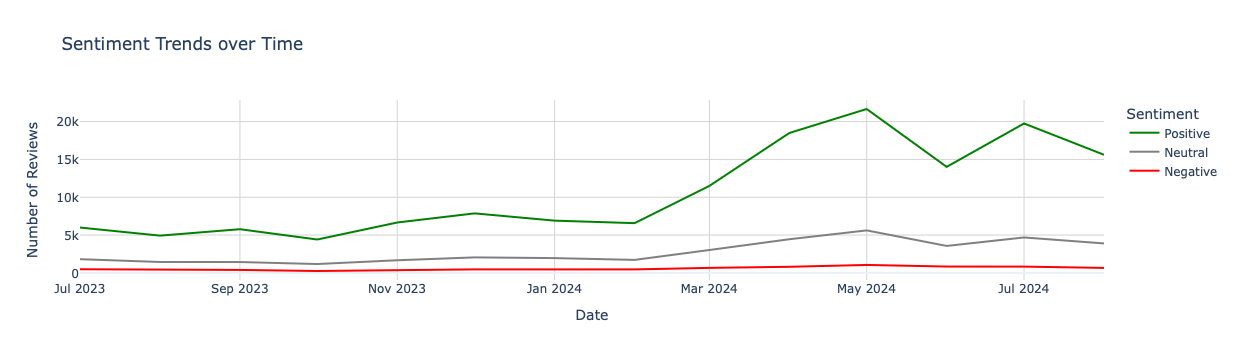

In [96]:
# Analyzing how reviews changed over time 

# convert review date to DateTime format
df['Review Date'] = pd.to_datetime(df['Review Date'])

#Aggregate sentiment counts by Date 
sentiment_over_time = df.groupby([df['Review Date'].dt.to_period('M'),'Sentiment']).size().unstack(fill_value=0)

# convert the period back to date Time for plotting 
sentiment_over_time.index=sentiment_over_time.index.to_timestamp()
fig = go.Figure()
fig.add_trace(go.Scatter(x=sentiment_over_time.index,y=sentiment_over_time['Positive'],mode='lines',name='Positive',line=dict(color='green')))
fig.add_trace(go.Scatter(x=sentiment_over_time.index,y=sentiment_over_time['Neutral'],mode='lines',name='Neutral',line=dict(color='gray')))
fig.add_trace(go.Scatter(x=sentiment_over_time.index,y=sentiment_over_time['Negative'],mode='lines',name='Negative',line=dict(color='red')))

fig.update_layout(
    title='Sentiment Trends over Time',
    xaxis_title='Date',
    yaxis_title='Number of Reviews',
    plot_bgcolor='white',
    paper_bgcolor='white',
    legend_title_text='Sentiment',
    xaxis=dict(showgrid=True,gridcolor='lightgray'),
    yaxis=dict(showgrid=True,gridcolor='lightgray'))

fig.show()



In [98]:
"""Analyzing how often users prompt ChatGPT 


    Promoters: Respondents who provide a score of 9 or 10.
    Passives: Respondents who provide a score of 7 or 8.
    Detractors: Respondents who provide a score between 0 and 6.

    
        NPS(Net Promoters Score) = %Promoters − %Detractors"""

# define Category based on rating
df['NPS Category'] = df['Ratings'].apply(lambda x:'Promoter' if x==5 else ('Passive' if x==4 else 'Detractor'))

# Calculate the percentage of each category 
nps_counts = df['NPS Category'].value_counts(normalize=True)*100

#Calculate NPS
nps_score = nps_counts.get('Promoter',0)-nps_counts.get('Detractor',0)

#Display the NPS Score 
print(nps_score)


64.35313912172705
